In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# CELDA 0: Instalación y configuración (ya colocaste esto; lo incluyo completo)
!apt-get update -y
!apt-get install -y xvfb

!pip install -q vizdoom==1.2.4 gymnasium==0.28.1 pyvirtualdisplay \
               imageio imageio-ffmpeg opencv-python-headless \
               torch torchvision numpy matplotlib

# Iniciar display virtual para rendering en headless (Kaggle)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 600))
display.start()


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,513 kB] 
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/pp

In [3]:
!mkdir -p scenarios
!wget https://raw.githubusercontent.com/mwydmuch/ViZDoom/master/scenarios/deadly_corridor.cfg -O scenarios/deadly_corridor.cfg
!wget https://raw.githubusercontent.com/mwydmuch/ViZDoom/master/scenarios/deadly_corridor.wad -O scenarios/deadly_corridor.wad


--2025-12-09 01:50:47--  https://raw.githubusercontent.com/mwydmuch/ViZDoom/master/scenarios/deadly_corridor.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1046 (1.0K) [text/plain]
Saving to: ‘scenarios/deadly_corridor.cfg’

scenarios/deadly_co 100%[===================>]   1.02K  --.-KB/s    in 0s      

2025-12-09 01:50:47 (55.8 MB/s) - ‘scenarios/deadly_corridor.cfg’ saved [1046/1046]

--2025-12-09 01:50:47--  https://raw.githubusercontent.com/mwydmuch/ViZDoom/master/scenarios/deadly_corridor.wad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respon

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from vizdoom import DoomGame, Mode, ScreenFormat, ScreenResolution
import gymnasium as gym
from gymnasium import spaces
import cv2
import torch


## **1. Wrapper Principal del Entorno**

In [5]:
# =============================================================
# 1. IMPORTACIONES
# =============================================================
import numpy as np
import torch
import cv2
from collections import deque
from vizdoom import DoomGame, Mode, ScreenResolution, Button, GameVariable


# =============================================================
# WRAPPER PRINCIPAL
# =============================================================
class VizDoomDeadlyCorridorEnv:
    """
    Wrapper principal para VizDoom Deadly Corridor.
    Incluye:
    - Resize a 84x84
    - Escala de grises
    - Normalización [0,1]
    - Frame stacking (4 frames)
    - Límite de pasos
    - Acciones ampliadas (7)
    """

    def __init__(self, frame_size=84, frame_stack=4, max_steps=2000):
        self.frame_size = frame_size
        self.frame_stack = frame_stack
        self.max_steps = max_steps
        self.step_count = 0

        # ---------------------------------------------------------
        # Inicializar Doom
        # ---------------------------------------------------------
        self.game = DoomGame()
        self.game.load_config("scenarios/deadly_corridor.cfg")
        self.game.set_window_visible(True)
        self.game.set_mode(Mode.PLAYER)
        self.game.set_screen_resolution(ScreenResolution.RES_640X480)
        self.game.init()

        # ---------------------------------------------------------
        # NUEVAS ACCIONES (7)
        # ---------------------------------------------------------
        self.actions = [
            [1,0,0,0,0,0,0],  # MOVE_LEFT
            [0,1,0,0,0,0,0],  # MOVE_RIGHT
            [0,0,1,0,0,0,0],  # ATTACK
            [0,0,0,1,0,0,0],  # MOVE_FORWARD
            [0,0,0,0,1,0,0],  # MOVE_BACKWARD
            [0,0,0,0,0,1,0],  # TURN_LEFT
            [0,0,0,0,0,0,1],  # TURN_RIGHT
        ]

        self.num_actions = len(self.actions)

        # ---------------------------------------------------------
        # Frame stack buffer
        # ---------------------------------------------------------
        self.frames = deque(maxlen=self.frame_stack)

    # =========================================================
    # RESET
    # =========================================================
    def reset(self):
        self.game.new_episode()
        self.step_count = 0

        # Obtener primer frame preprocesado
        frame = self._get_preprocessed_frame()

        # Llenar buffer
        for _ in range(self.frame_stack):
            self.frames.append(frame)

        return torch.stack(list(self.frames), dim=0)

    # =========================================================
    # STEP
    # =========================================================
    def step(self, action_idx):

        reward = self.game.make_action(self.actions[action_idx], 1)
        self.step_count += 1

        done = self.game.is_episode_finished() or self.step_count >= self.max_steps

        if done:
            return None, reward, True, {}

        frame = self._get_preprocessed_frame()
        self.frames.append(frame)

        stacked = torch.stack(list(self.frames), dim=0)
        return stacked, reward, done, {}

    # =========================================================
    # PREPROCESAMIENTO
    # =========================================================
    def _get_preprocessed_frame(self):
        state = self.game.get_state()
        frame = state.screen_buffer  # (C,H,W)

        # Convertir CxHxW → HxWxC
        frame = np.transpose(frame, (1, 2, 0))

        # Escala de grises
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize
        resized = cv2.resize(gray, (self.frame_size, self.frame_size))

        # Normalizar
        normalized = resized.astype(np.float32) / 255.0

        return torch.from_numpy(normalized)

## **2.Wrapper Reward Shaper**

In [6]:
# =============================================================
# WRAPPER DE RECOMPENSAS
# =============================================================
class DeadlyCorridorRewardShaper:
    def __init__(
        self, env,
        k_progress=1.0,
        k_damage=-0.5,
        k_miss=-0.1,
        k_frag=20.0
    ):
        self.env = env
        self.game = env.game

        # Forward de variables necesarias
        self.num_actions = env.num_actions
        self.actions = env.actions

        # Parámetros de shaping
        self.k_progress = k_progress
        self.k_damage = k_damage
        self.k_miss = k_miss
        self.k_frag = k_frag


        # Variables previas
        self.prev_x = None
        self.prev_hp = None
        self.prev_frag = None

        # Para evitar devolver None
        self.last_valid_obs = None

        # Índice del botón ATTACK
        buttons = list(self.game.get_available_buttons())
        self.attack_idx = buttons.index(Button.ATTACK)

    # ---------------------------------------------------------
    def reset(self):
        obs = self.env.reset()
        self.last_valid_obs = obs

        self.prev_x = self.game.get_game_variable(GameVariable.POSITION_X)
        self.prev_hp = self.game.get_game_variable(GameVariable.HEALTH)
        self.prev_frag = self.game.get_game_variable(GameVariable.FRAGCOUNT)

        return obs

    def get_screen(self):
        base = self.env   # saltamos directamente el primer nivel

        # Descender sólo si el objeto tiene atributo env y NO es él mismo
        while hasattr(base, "env") and base.env is not base:
            base = base.env

        # Si el entorno real tiene get_screen()
        if hasattr(base, "get_screen"):
            return base.get_screen()

        # Si el entorno es Gym
        if hasattr(base, "render"):
            return base.render(mode="rgb_array")

        raise AttributeError("El entorno no tiene método get_screen ni render()")



    # ---------------------------------------------------------
    def step(self, action_idx):
        obs, base_reward, done, info = self.env.step(action_idx)

        # Guardar último frame válido
        if obs is not None:
            self.last_valid_obs = obs

        # Variables del juego
        x = self.game.get_game_variable(GameVariable.POSITION_X)
        hp = self.game.get_game_variable(GameVariable.HEALTH)
        frag = self.game.get_game_variable(GameVariable.FRAGCOUNT)

        # ---------------------------------------------------------
        # RECOMPENSA MOLDEADA
        # ---------------------------------------------------------
        shaped_reward = base_reward

        # Progreso (avanzar en X)
        dx = x - self.prev_x
        shaped_reward += self.k_progress * dx

        # Daño recibido
        damage = max(self.prev_hp - hp, 0)
        shaped_reward += self.k_damage * damage

        # Disparo fallado
        last_action = self.game.get_last_action()[self.attack_idx]
        miss = (last_action == 1 and frag == self.prev_frag)
        if miss:
            shaped_reward += self.k_miss

        # Matar enemigo
        if frag > self.prev_frag:
            shaped_reward += self.k_frag

        # Actualizar estado previo
        self.prev_x = x
        self.prev_hp = hp
        self.prev_frag = frag

        # Si muere el episodio, devolver el último frame válido
        if done:
            return self.last_valid_obs, shaped_reward, done, info

        return obs, shaped_reward, done, info

## **3. Entorno Deadly_Corridor**

In [7]:
def make_deadly_corridor_env():
    env = VizDoomDeadlyCorridorEnv()
    env = DeadlyCorridorRewardShaper(env)
    return env



=== EJECUCIÓN DEL EPISODIO (TEXTO) ===

Paso 1/20 | Acción = 4 | Recompensa = 0.0
Paso 2/20 | Acción = 6 | Recompensa = 0.0
Paso 3/20 | Acción = 0 | Recompensa = 0.0
Paso 4/20 | Acción = 3 | Recompensa = 0.0
Paso 5/20 | Acción = 6 | Recompensa = 0.0
Paso 6/20 | Acción = 0 | Recompensa = 0.0
Paso 7/20 | Acción = 6 | Recompensa = 0.0
Paso 8/20 | Acción = 5 | Recompensa = 0.0
Paso 9/20 | Acción = 6 | Recompensa = 0.0
Paso 10/20 | Acción = 1 | Recompensa = 0.0
Paso 11/20 | Acción = 3 | Recompensa = 1.5625
Paso 12/20 | Acción = 1 | Recompensa = 1.416015625
Paso 13/20 | Acción = 3 | Recompensa = 2.84576416015625
Paso 14/20 | Acción = 6 | Recompensa = 2.578948974609375
Paso 15/20 | Acción = 1 | Recompensa = 2.29229736328125
Paso 16/20 | Acción = 5 | Recompensa = 2.077392578125
Paso 17/20 | Acción = 6 | Recompensa = 1.88262939453125
Paso 18/20 | Acción = 2 | Recompensa = 1.60611572265625
Paso 19/20 | Acción = 5 | Recompensa = -13.453857421875
Paso 20/20 | Acción = 4 | Recompensa = -6.85269165

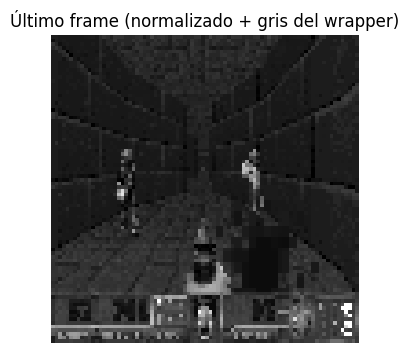

🎬 Reproducción del video del episodio:


In [8]:
import imageio
import cv2
import numpy as np
import base64
import IPython
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
import time

# ===================================================
# Función para embeber el video en el notebook (igual a tu ejemplo)
# ===================================================
def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = f'''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''
    return IPython.display.HTML(tag)


# ===================================================
# Ejecución de un episodio simple para evaluación
# ===================================================
def run_doom_episode_and_render(filename="doom_eval", max_steps=20, fps=15):

    env = make_deadly_corridor_env()
    obs = env.reset()

    frames_for_video = []
    last_obs = None

    print("\n=== EJECUCIÓN DEL EPISODIO (TEXTO) ===\n")

    for step in range(max_steps):

        # Acción aleatoria válida
        action = np.random.randint(0, env.num_actions)

        # Ejecutar acción
        obs, reward, done, _ = env.step(action)
        last_obs = obs  # guardar última obs normalizada / gris del wrapper

        # -----------------------------
        # Obtener frame RGB del juego
        # -----------------------------
        state = env.game.get_state()
        if state is not None:
            frame_rgb = state.screen_buffer
            frame_rgb = np.transpose(frame_rgb, (1, 2, 0))  # CxHxW → HxWxC

            # agregar al video
            frames_for_video.append(frame_rgb)

        # Imprimir info
        print(f"Paso {step+1}/{max_steps} | Acción = {action} | Recompensa = {reward}")

        if done:
            print("\n➡ Episodio terminó antes del número máximo de pasos.")
            break

    # =================================================
    # GUARDAR VIDEO .MP4
    # =================================================
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video_writer:
        for frame in frames_for_video:
            video_writer.append_data(frame)

    print(f"\n🎥 Video guardado en: {filename}\n")

    # =================================================
    # MOSTRAR ÚLTIMO FRAME TAL COMO LO ENTREGA EL WRAPPER
    # =================================================
    plt.figure(figsize=(4, 4))
    plt.imshow(last_obs[-1], cmap="gray")
    plt.title("Último frame (normalizado + gris del wrapper)")
    plt.axis("off")
    plt.show()

    # =================================================
    # MOSTRAR VIDEO
    # =================================================
    print("🎬 Reproducción del video del episodio:")
    display(embed_mp4(filename))
    

# ===================================================
# Ejecutar episodio
# ===================================================
run_doom_episode_and_render("doom_eval_run", max_steps=20, fps=15)


## **4. Replay Buffer**

In [9]:
import numpy as np
import torch
from typing import Tuple

class ReplayBuffer:
    """
    Replay buffer circular para transiciones (s, a, r, s', done).
    - Almacena estados como numpy.float32 (forma: (C,H,W))
    - Añade transiciones una a una con add(...)
    - sample(batch_size) devuelve un batch aleatorio
    """
    def __init__(self, state_shape: Tuple[int,int,int], max_size: int = 100000, device='cpu'):
        self.max_size = int(max_size)
        self.state_shape = state_shape  # ejemplo: (4,84,84)
        self.device = device

        # buffers numpy prealocados (memoria contigua)
        self.states = np.zeros((self.max_size, *state_shape), dtype=np.float32)
        self.next_states = np.zeros((self.max_size, *state_shape), dtype=np.float32)
        self.actions = np.zeros((self.max_size,), dtype=np.int64)
        self.rewards = np.zeros((self.max_size,), dtype=np.float32)
        self.dones = np.zeros((self.max_size,), dtype=np.uint8)

        self.ptr = 0           # índice circular donde escribir la próxima transición
        self.size = 0          # cuántas transiciones hay almacenadas

    def add(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        """
        Añade una transición al buffer.
        state, next_state: numpy arrays con shape == state_shape (float32, normalizados)
        """
        idx = self.ptr
        self.states[idx] = state
        self.next_states[idx] = next_state
        self.actions[idx] = int(action)
        self.rewards[idx] = float(reward)
        self.dones[idx] = 1 if done else 0

        # avanzar puntero circular
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size: int):
        """
        Muestra un batch aleatorio de transiciones.
        Devuelve tensores torch ya enviados a self.device.
        """
        assert self.size > 0, "ReplayBuffer vacío. Llama a collect_random_data primero."
        batch_size = min(batch_size, self.size)
        idxs = np.random.randint(0, self.size, size=batch_size)

        states = torch.from_numpy(self.states[idxs]).to(self.device)
        next_states = torch.from_numpy(self.next_states[idxs]).to(self.device)
        actions = torch.from_numpy(self.actions[idxs]).to(self.device)
        rewards = torch.from_numpy(self.rewards[idxs]).to(self.device)
        dones = torch.from_numpy(self.dones[idxs]).to(self.device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return self.size


In [10]:
import time
from tqdm import trange

def collect_random_data(env, buffer: ReplayBuffer, num_steps: int, max_episode_steps: int = 2000, show_progress: bool = True):
    """
    Llena el replay buffer con transiciones tomadas por una política completamente aleatoria.
    - env: tu wrapper (make_deadly_corridor_env())
    - buffer: instancia ReplayBuffer
    - num_steps: número total de pasos (transiciones) a recolectar
    """
    steps_collected = 0
    obs = env.reset()  # tensor (C,H,W) de torch
    # convertir a numpy para almacenamiento (float32)
    state = obs.numpy()

    pbar = trange(num_steps) if show_progress else range(num_steps)
    for _ in pbar:
        # acción aleatoria válida
        action = np.random.randint(0, env.num_actions)

        next_obs, reward, done, _ = env.step(action)

        # Si el wrapper devuelve None cuando termina, usamos el último frame válido guardado en reward-shaper.
        if next_obs is None:
            # el reward-shaper ya está devolviendo last_valid_obs cuando done
            next_state = env.last_valid_obs.numpy()  # fallback
        else:
            next_state = next_obs.numpy()

        # Añadir transición al buffer
        buffer.add(state, action, reward, next_state, done)
        steps_collected += 1

        # Avanzar
        if done:
            obs = env.reset()
            state = obs.numpy()
        else:
            state = next_state

        if show_progress:
            pbar.set_description(f"Collected {steps_collected}/{num_steps}")

    return steps_collected


In [11]:
from torch.utils.data import IterableDataset, DataLoader

class ReplayBufferDataset(IterableDataset):
    """
    IterableDataset que genera batches a partir de ReplayBuffer.sample(batch_size).
    Útil para usar con DataLoader(num_workers=0) o para entrenamientos donde queremos muestrear continuamente.
    """
    def __init__(self, buffer: ReplayBuffer, batch_size: int, batches_per_epoch: int = 1000):
        super().__init__()
        self.buffer = buffer
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch

    def __iter__(self):
        # En un escenario real puedes preferir una semilla por worker, etc.
        for _ in range(self.batches_per_epoch):
            states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
            # yield diccionario o tupla, según convenga al training loop
            yield {
                'states': states,           # (B, C, H, W)
                'actions': actions,         # (B,)
                'rewards': rewards,         # (B,)
                'next_states': next_states, # (B, C, H, W)
                'dones': dones              # (B,)
            }


## **5. Red Q-network**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """
    Red neuronal para aproximar Q(s,a).
    Recibe: 4 frames apilados de 84x84
    Devuelve: Q-values para cada acción (7 acciones).
    """
    def __init__(self, num_actions):
        super(DQN, self).__init__()

        # ---- CAPAS CONVOLUCIONALES ----
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)   # -> 32 x 20 x 20
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  # -> 64 x 9 x 9
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  # -> 64 x 7 x 7

        # Cálculo del tamaño después de convoluciones: 64*7*7 = 3136
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        # x shape: (batch, 4, 84, 84)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # Q-values


## **6. Agente- DQN**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

class DQNAgent:
    """
    DQN clásico: red online, red target, epsilon greedy.
    """
    def __init__(self, num_actions, gamma=0.99, lr=2.5e-4, epsilon_start=1.0, 
                 epsilon_end=0.05, epsilon_decay=50000):

        self.num_actions = num_actions
        self.gamma = gamma
        
        # ---- RED ONLINE ----
        self.q_network = DQN(num_actions).cuda()

        # ---- RED TARGET ----
        self.target_network = DQN(num_actions).cuda()
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # ---- OPTIMIZADOR ----
        self.optimizer = optim.RMSprop(
            self.q_network.parameters(),
            lr=lr,
            alpha=0.95,
            eps=1e-5
        )

        # ---- EPSILON GREEDY ----
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon_step = 0

    # Política epsilon-greedy
    def select_action(self, state):
        self.epsilon_step += 1
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon - (1.0 - self.epsilon_end) / self.epsilon_decay
        )

        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)

        state = state.unsqueeze(0).cuda()  # batch=1
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.argmax(dim=1).item()

    # Copiar pesos online -> target cada cierto tiempo
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, path):
        torch.save({
            "qnet": self.qnet.state_dict(),
            "target_qnet": self.target_qnet.state_dict(),
        }, path)
        print(f"[OK] Modelo guardado en {path}")

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.qnet.load_state_dict(checkpoint["qnet"])
        self.target_qnet.load_state_dict(checkpoint["target_qnet"])
        print(f"[OK] Modelo cargado desde {path}")
    


In [14]:
# =========================
# TRAINING SCRIPT (CORREGIDO)
# =========================
import os
import time
from collections import deque
from tqdm import trange
import random
import numpy as np
import torch
import torch.nn as nn

# --- HYPERPARAMS (ajusta si quieres) ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42

max_training_steps = 500_000            # pasos de interacción total
buffer_size = 100_000
warmup_steps = 10_000                   # pasos aleatorios iniciales para llenar buffer
train_freq = 4                          # cada cuántos pasos del entorno se hace 1 paso de optimización
batch_size = 32
batches_per_update = 1                  # cuántos batches por actualización (para acumular gradientes si se desea)
target_update_freq = 1000               # pasos ambiente entre actualizaciones target <- online
eval_interval = 20_000                  # pasos entre evaluaciones
eval_episodes = 5
learning_rate = 2.5e-4
gamma = 0.99
save_path = './checkpoints'
os.makedirs(save_path, exist_ok=True)

# reproducibilidad
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)

# --- Crear entornos (train & eval) ---
train_env = make_deadly_corridor_env()   # tu wrapper devuelve env con reward-shaper
eval_env = make_deadly_corridor_env()    # otro entorno independiente para evaluación

# número de acciones (el reward-shaper expone num_actions)
num_actions = train_env.num_actions

# CORRECCIÓN: acceder a los atributos del env interior (VizDoomDeadlyCorridorEnv)
state_shape = (
    train_env.env.frame_stack,
    train_env.env.frame_size,
    train_env.env.frame_size
)

# --- Crear buffer y agente ---
replay_buffer = ReplayBuffer(state_shape=state_shape, max_size=buffer_size, device=device)
agent = DQNAgent(num_actions=num_actions, gamma=gamma, lr=learning_rate)

# Aseguramos que las redes del agente estén en device (si tu DQNAgent usó .cuda() internamente, esto las mantiene en GPU)
agent.q_network.to(device)
agent.target_network.to(device)

# --- Warmup: recolección aleatoria ---
print(f"Warmup: colectando {warmup_steps} pasos aleatorios en el buffer...")
collect_random_data(train_env, replay_buffer, num_steps=warmup_steps, show_progress=True)
print(f"Buffer size tras warmup: {len(replay_buffer)}")

# --- Dataset + DataLoader (opcional, usamos iterable) ---
dataset = ReplayBufferDataset(replay_buffer, batch_size=batch_size, batches_per_epoch=10**6)
data_iter = iter(dataset)  # iterable que llama a buffer.sample

# --- Función de evaluación (run greedy episodes en eval_env) ---
def evaluate(agent, env, n_episodes=5, max_steps_per_ep=2000):
    agent.q_network.eval()
    total_rewards = []
    for ep in range(n_episodes):
        obs = env.reset()  # tensor (C,H,W)
        state = obs.cpu()  # mantener en cpu para env
        ep_reward = 0.0
        steps = 0
        done = False
        while not done and steps < max_steps_per_ep:
            # greedy (epsilon=0)
            with torch.no_grad():
                s = state.unsqueeze(0).to(device)  # (1,C,H,W)
                q = agent.q_network(s)
                action = q.argmax(dim=1).item()
            next_obs, reward, done, _ = env.step(action)
            if next_obs is None:
                next_state = env.last_valid_obs
            else:
                next_state = next_obs
            state = next_state.cpu()
            ep_reward += reward
            steps += 1
        total_rewards.append(ep_reward)
    agent.q_network.train()
    return float(np.mean(total_rewards)), float(np.std(total_rewards))

# --- Training loop variables ---
step_count = 0
episode_count = 0
episode_reward = 0.0

# iniciar episodio
obs = train_env.reset()  # tensor (C,H,W)
state = obs.numpy()

# optimizer ya creado en agent
optimizer = agent.optimizer
mse_loss = nn.MSELoss()

pbar = trange(max_training_steps, desc="Training steps")
last_eval_time = time.time()

for global_step in pbar:
    step_count += 1

    # Seleccionar acción (epsilon-greedy del agente)
    action = agent.select_action(torch.from_numpy(state).to(device).float())  # recibe tensor
    next_obs, reward, done, _ = train_env.step(action)

    # manejar next_state nulo (cuando reward-shaper devolvió None)
    if next_obs is None:
        next_state_np = train_env.last_valid_obs.numpy()
    else:
        next_state_np = next_obs.numpy()

    # Añadir al buffer (usa numpy)
    replay_buffer.add(state, action, reward, next_state_np, done)
    episode_reward += reward

    # Avanzar estado / reiniciar al terminar episodio
    if done:
        episode_count += 1
        pbar.set_postfix({'ep': episode_count, 'ep_reward': f"{episode_reward:.2f}", 'buffer': len(replay_buffer)})
        obs = train_env.reset()
        state = obs.numpy()
        episode_reward = 0.0
    else:
        state = next_state_np

    # ---- Optimización (cada train_freq pasos) ----
    if (global_step > warmup_steps) and (global_step % train_freq == 0):
        # realizar un número de updates (batches_per_update)
        for _ in range(batches_per_update):
            # obtener batch directamente del buffer
            states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(batch_size)

            # asegurarse de tipos y device
            states_b = states_b.to(device).float()            # (B, C, H, W)
            next_states_b = next_states_b.to(device).float()
            actions_b = actions_b.to(device).long()           # (B,)
            rewards_b = rewards_b.to(device).float()          # (B,)
            dones_b = dones_b.to(device).float()              # (B,)  (0.0 o 1.0)

            # Q(s,a) online
            q_values = agent.q_network(states_b)              # (B, num_actions)
            q_values_a = q_values.gather(1, actions_b.unsqueeze(1)).squeeze(1)  # (B,)

            # target: r + gamma * max_a' Q_target(s', a') * (1 - done)
            with torch.no_grad():
                next_q = agent.target_network(next_states_b)  # (B, num_actions)
                next_q_max, _ = next_q.max(dim=1)             # (B,)
                target_q = rewards_b + gamma * next_q_max * (1.0 - dones_b)

            # loss & backprop
            loss = mse_loss(q_values_a, target_q)

            optimizer.zero_grad()
            loss.backward()
            # clipping gradientes (opcional)
            torch.nn.utils.clip_grad_norm_(agent.q_network.parameters(), 10.0)
            optimizer.step()

    # ---- Actualizar target network periódicamente ----
    if global_step % target_update_freq == 0 and global_step > 0:
        agent.update_target_network()

    # ---- Evaluación periódica ----
    if global_step % eval_interval == 0 and global_step > 0:
        mean_r, std_r = evaluate(agent, eval_env, n_episodes=eval_episodes)
        print(f"\n[Eval] step={global_step} mean_reward={mean_r:.2f} std={std_r:.2f}")
        # guardar modelo
        save_file = os.path.join(save_path, f"dqn_step{global_step}_rew{mean_r:.2f}.pth")
        torch.save(agent.q_network.state_dict(), save_file)
        print(f"[Checkpoint saved] {save_file}")

    # progreso en barra
    if global_step % 100 == 0:
        pbar.set_postfix({
            'step': global_step,
            'buffer': len(replay_buffer),
            'eps': f"{agent.epsilon:.3f}"
        })

# al finalizar entrenamiento
final_save = os.path.join(save_path, "dqn_final.pth")
torch.save(agent.q_network.state_dict(), final_save)
print(f"Entrenamiento finalizado. Modelo guardado en: {final_save}")


Warmup: colectando 10000 pasos aleatorios en el buffer...


Collected 10000/10000: 100%|██████████| 10000/10000 [01:30<00:00, 110.81it/s]


Buffer size tras warmup: 10000


Training steps:   4%|▍         | 20013/500000 [03:09<7:59:27, 16.68it/s, step=2e+4, buffer=3e+4, eps=0.620]       


[Eval] step=20000 mean_reward=417.36 std=312.22
[Checkpoint saved] ./checkpoints/dqn_step20000_rew417.36.pth


Training steps:   8%|▊         | 40015/500000 [06:43<8:23:38, 15.22it/s, ep=505, ep_reward=343.38, buffer=5e+4]   


[Eval] step=40000 mean_reward=209.83 std=130.80
[Checkpoint saved] ./checkpoints/dqn_step40000_rew209.83.pth


Training steps:  12%|█▏        | 60016/500000 [10:23<8:24:45, 14.53it/s, step=6e+4, buffer=7e+4, eps=0.050]       


[Eval] step=60000 mean_reward=515.91 std=351.84
[Checkpoint saved] ./checkpoints/dqn_step60000_rew515.91.pth


Training steps:  16%|█▌        | 80013/500000 [14:04<8:56:54, 13.04it/s, ep=1154, ep_reward=175.28, buffer=9e+4]  


[Eval] step=80000 mean_reward=474.34 std=413.84
[Checkpoint saved] ./checkpoints/dqn_step80000_rew474.34.pth


Training steps:  20%|██        | 100008/500000 [17:41<7:29:41, 14.82it/s, ep=1459, ep_reward=436.23, buffer=1e+5]  


[Eval] step=100000 mean_reward=145.80 std=105.36
[Checkpoint saved] ./checkpoints/dqn_step100000_rew145.80.pth


Training steps:  24%|██▍       | 120012/500000 [21:19<6:52:50, 15.34it/s, step=120000, buffer=1e+5, eps=0.050]     


[Eval] step=120000 mean_reward=465.39 std=309.80
[Checkpoint saved] ./checkpoints/dqn_step120000_rew465.39.pth


Training steps:  28%|██▊       | 140016/500000 [24:57<6:15:37, 15.97it/s, step=140000, buffer=1e+5, eps=0.050]     


[Eval] step=140000 mean_reward=442.67 std=297.87
[Checkpoint saved] ./checkpoints/dqn_step140000_rew442.67.pth


Training steps:  32%|███▏      | 160012/500000 [28:33<6:20:49, 14.88it/s, step=160000, buffer=1e+5, eps=0.050]    


[Eval] step=160000 mean_reward=444.73 std=441.56
[Checkpoint saved] ./checkpoints/dqn_step160000_rew444.73.pth


Training steps:  36%|███▌      | 180016/500000 [32:11<5:31:34, 16.08it/s, step=180000, buffer=1e+5, eps=0.050]    


[Eval] step=180000 mean_reward=361.55 std=295.40
[Checkpoint saved] ./checkpoints/dqn_step180000_rew361.55.pth


Training steps:  40%|████      | 200013/500000 [35:49<6:07:39, 13.60it/s, step=2e+5, buffer=1e+5, eps=0.050]      


[Eval] step=200000 mean_reward=492.70 std=378.26
[Checkpoint saved] ./checkpoints/dqn_step200000_rew492.70.pth


Training steps:  44%|████▍     | 220013/500000 [39:27<4:30:08, 17.27it/s, ep=3359, ep_reward=275.06, buffer=1e+5]


[Eval] step=220000 mean_reward=196.80 std=66.16
[Checkpoint saved] ./checkpoints/dqn_step220000_rew196.80.pth


Training steps:  48%|████▊     | 240014/500000 [43:07<5:08:27, 14.05it/s, ep=3674, ep_reward=53.53, buffer=1e+5]  


[Eval] step=240000 mean_reward=215.56 std=94.10
[Checkpoint saved] ./checkpoints/dqn_step240000_rew215.56.pth


Training steps:  52%|█████▏    | 260010/500000 [46:48<6:58:04,  9.57it/s, step=260000, buffer=1e+5, eps=0.050]   


[Eval] step=260000 mean_reward=605.55 std=343.80
[Checkpoint saved] ./checkpoints/dqn_step260000_rew605.55.pth


Training steps:  56%|█████▌    | 280017/500000 [50:28<4:28:08, 13.67it/s, step=280000, buffer=1e+5, eps=0.050]   


[Eval] step=280000 mean_reward=514.48 std=347.04
[Checkpoint saved] ./checkpoints/dqn_step280000_rew514.48.pth


Training steps:  60%|██████    | 300013/500000 [54:06<4:07:32, 13.47it/s, step=3e+5, buffer=1e+5, eps=0.050]     


[Eval] step=300000 mean_reward=590.26 std=278.08
[Checkpoint saved] ./checkpoints/dqn_step300000_rew590.26.pth


Training steps:  64%|██████▍   | 320010/500000 [57:45<2:57:30, 16.90it/s, ep=4959, ep_reward=338.81, buffer=1e+5]


[Eval] step=320000 mean_reward=218.59 std=71.95
[Checkpoint saved] ./checkpoints/dqn_step320000_rew218.59.pth


Training steps:  68%|██████▊   | 340013/500000 [1:01:24<2:57:30, 15.02it/s, step=340000, buffer=1e+5, eps=0.050]   


[Eval] step=340000 mean_reward=536.95 std=307.42
[Checkpoint saved] ./checkpoints/dqn_step340000_rew536.95.pth


Training steps:  72%|███████▏  | 360010/500000 [1:05:02<3:10:11, 12.27it/s, step=360000, buffer=1e+5, eps=0.050]   


[Eval] step=360000 mean_reward=229.60 std=228.87
[Checkpoint saved] ./checkpoints/dqn_step360000_rew229.60.pth


Training steps:  76%|███████▌  | 380012/500000 [1:08:43<2:03:04, 16.25it/s, step=380000, buffer=1e+5, eps=0.050]   


[Eval] step=380000 mean_reward=366.69 std=258.15
[Checkpoint saved] ./checkpoints/dqn_step380000_rew366.69.pth


Training steps:  80%|████████  | 400018/500000 [1:12:22<1:42:12, 16.30it/s, step=4e+5, buffer=1e+5, eps=0.050]     


[Eval] step=400000 mean_reward=332.60 std=287.89
[Checkpoint saved] ./checkpoints/dqn_step400000_rew332.60.pth


Training steps:  84%|████████▍ | 420012/500000 [1:16:01<1:45:16, 12.66it/s, ep=6561, ep_reward=110.93, buffer=1e+5]


[Eval] step=420000 mean_reward=662.65 std=276.50
[Checkpoint saved] ./checkpoints/dqn_step420000_rew662.65.pth


Training steps:  88%|████████▊ | 440018/500000 [1:19:40<47:59, 20.83it/s, step=440000, buffer=1e+5, eps=0.050]     


[Eval] step=440000 mean_reward=140.83 std=250.22
[Checkpoint saved] ./checkpoints/dqn_step440000_rew140.83.pth


Training steps:  92%|█████████▏| 460014/500000 [1:23:17<40:57, 16.27it/s, ep=7186, ep_reward=96.77, buffer=1e+5]   


[Eval] step=460000 mean_reward=388.16 std=270.34
[Checkpoint saved] ./checkpoints/dqn_step460000_rew388.16.pth


Training steps:  96%|█████████▌| 480021/500000 [1:26:55<19:19, 17.23it/s, step=480000, buffer=1e+5, eps=0.050]     


[Eval] step=480000 mean_reward=418.15 std=232.91
[Checkpoint saved] ./checkpoints/dqn_step480000_rew418.15.pth


Training steps: 100%|██████████| 500000/500000 [1:30:31<00:00, 92.06it/s, ep=7827, ep_reward=591.50, buffer=1e+5]  

Entrenamiento finalizado. Modelo guardado en: ./checkpoints/dqn_final.pth


In [30]:
import torch
import imageio
import numpy as np
from IPython.display import Video, display

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# =============================================================
# PLAY & RECORD (modelo entrenado o random)
# =============================================================
def play_and_record(model_path=None, 
                    vid="doom_deadly_corridor_eval.mp4", 
                    episodes=1, 
                    random_actions=False):

    # Crear un entorno limpio para evaluación
    env = make_deadly_corridor_env()

    # Si NO es random, cargar modelo entrenado
    if not random_actions:
        print(f"Cargando modelo: {model_path}")
        num_actions = env.num_actions
        agent = DQNAgent(num_actions=num_actions)  # crea redes
        agent.q_network.load_state_dict(torch.load(model_path, map_location=device))
        agent.q_network.to(device)
        agent.q_network.eval()
    else:
        print("Ejecutando con acciones RANDOM...")
        agent = None  # no se usa red

    frames = []
    episode_rewards = []

    for ep in range(episodes):
        obs = env.reset()      # tensor (C,H,W)
        state = obs.to(device).float()
        done = False
        ep_reward = 0.0

        while not done:
            # ----- Acción -----
            if random_actions:
                action = np.random.randint(env.num_actions)
            else:
                with torch.no_grad():
                    q = agent.q_network(state.unsqueeze(0))  # (1,C,H,W)
                    action = q.argmax(dim=1).item()

            # ----- Step -----
            next_obs, reward, done, _ = env.step(action)
            ep_reward += reward

            # Manejo del caso donde reward-shaper devuelve None
            if next_obs is None:
                state = env.last_valid_obs.to(device).float()
            else:
                state = next_obs.to(device).float()

            # ----- Capturar frame RGB -----
            rgb = env.render(mode='rgb_array')
            frames.append(rgb)

        episode_rewards.append(ep_reward)
        print(f"Episodio {ep+1}/{episodes} terminado → Reward: {ep_reward:.2f}")

    env.close()

    # Guardar video
    print(f"Guardando video en: {vid}")
    imageio.mimsave(vid, frames, fps=30)

    return vid, episode_rewards
